# QLoRA Parameter Test: Alpha Scaling - Ministral-3B-Reasoning

Tests different `lora_alpha` values (8, 16, 32, 64) with fixed rank r=16 to understand the effective learning rate multiplier.

**Key concept:** The effective LoRA scaling is `alpha/r`, which acts as a learning rate multiplier for the adapter weights.

**Alpha/Rank ratios tested:**
- α=8, r=16 → 0.5x scaling (conservative)
- α=16, r=16 → 1.0x scaling (standard)
- α=32, r=16 → 2.0x scaling (aggressive)
- α=64, r=16 → 4.0x scaling (very aggressive)

**Key features tested:**
- Training curves comparison (loss per step)
- Convergence speed differences
- Final loss comparison
- Stability across different scaling factors

**Model:** Ministral-3B-Reasoning with `[THINK]...[/THINK]` reasoning format

**Important:** This notebook includes a kernel shutdown cell at the end to release all GPU memory.

In [1]:
# Environment Setup
import os
from dotenv import load_dotenv
load_dotenv()

# Force text-based progress instead of HTML widgets
os.environ["TQDM_NOTEBOOK"] = "false"

# CRITICAL: Import unsloth FIRST for proper TRL patching
import unsloth
from unsloth import FastLanguageModel, is_bf16_supported

import torch
import gc

# Environment summary
gpu = torch.cuda.get_device_name(0) if torch.cuda.is_available() else "CPU"
print(f"Environment: unsloth {unsloth.__version__}, PyTorch {torch.__version__}, {gpu}")
print(f"HF_TOKEN loaded: {'Yes' if os.environ.get('HF_TOKEN') else 'No'}")

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


/opt/pixi/.pixi/envs/default/lib/python3.13/site-packages/trl/__init__.py:203: UserWarning: TRL currently supports vLLM versions: 0.10.2, 0.11.0, 0.11.1, 0.11.2. You have version 0.14.0rc1.dev201+gadcf682fc.cu130 installed. We recommend installing a supported version to avoid compatibility issues.
  if is_vllm_available():


🦥 Unsloth Zoo will now patch everything to make training faster!


Environment: unsloth 2025.12.10, PyTorch 2.9.1+cu130, NVIDIA GeForce RTX 4080 SUPER
HF_TOKEN loaded: Yes


In [2]:
# Benchmark Helper Functions
import subprocess

def measure_gpu_memory():
    """Measure current GPU memory usage in MB using nvidia-smi"""
    try:
        result = subprocess.run(
            ['nvidia-smi', '--query-gpu=memory.used', '--format=csv,noheader,nounits'],
            capture_output=True, text=True
        )
        return int(result.stdout.strip().split('\n')[0])
    except:
        return 0

def count_parameters(model):
    """Count trainable vs total parameters"""
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    return {
        "trainable": trainable,
        "total": total,
        "pct": 100 * trainable / total
    }

def cleanup_memory():
    """Force garbage collection and clear CUDA cache"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        torch.cuda.synchronize()

print("Benchmark functions defined.")
print(f"Initial GPU memory: {measure_gpu_memory()} MB")

Benchmark functions defined.
Initial GPU memory: 1914 MB


In [3]:
# Create minimal synthetic instruction dataset with thinking content (5 samples)
from datasets import Dataset

# Same dataset across all alpha values for fair comparison
synthetic_data = [
    {
        "instruction": "What is machine learning?",
        "thinking": "What is the user asking here? They want to understand machine learning. What are the key concepts I should cover? It's a subset of AI... and it involves learning from data. How should I keep this accessible? Short and clear definition.",
        "response": "Machine learning is a subset of artificial intelligence where computers learn patterns from data."
    },
    {
        "instruction": "Explain Python in one sentence.",
        "thinking": "One sentence only - what's most important about Python? Its readability and versatility are the defining features. How do I capture both in one sentence?",
        "response": "Python is a high-level programming language known for its readability and versatility."
    },
    {
        "instruction": "What is a neural network?",
        "thinking": "How do I explain neural networks simply? What's the core concept? They're inspired by biological neurons... they process information in layers. Should I mention deep learning? Maybe keep it basic for now.",
        "response": "A neural network is a computational model inspired by biological neurons that processes information through connected layers."
    },
    {
        "instruction": "Define supervised learning.",
        "thinking": "What makes supervised learning 'supervised'? It's the labels! The data has known outputs. How do I explain this clearly? Focus on the training process with labeled data.",
        "response": "Supervised learning is training a model on labeled data to predict outcomes for new inputs."
    },
    {
        "instruction": "What is gradient descent?",
        "thinking": "This is a bit technical. What's the intuition behind gradient descent? It's like walking downhill to find the lowest point. The gradient tells us which direction is 'down'. Keep it conceptual.",
        "response": "Gradient descent is an optimization algorithm that minimizes loss by iteratively adjusting parameters in the direction of steepest descent."
    },
]

print(f"Synthetic dataset prepared: {len(synthetic_data)} samples")

Synthetic dataset prepared: 5 samples


In [ ]:
# Alpha Scaling Comparison Loop
from trl import SFTTrainer, SFTConfig
from transformers import TrainerCallback

MODEL_NAME = "unsloth/Ministral-3-3B-Reasoning-2512"
FIXED_RANK = 16
ALPHAS = [8, 16, 32, 64]
results = []

# Custom callback to capture training history
class LossHistoryCallback(TrainerCallback):
    def __init__(self):
        self.losses = []
    
    def on_log(self, args, state, control, logs=None, **kwargs):
        if logs and 'loss' in logs:
            self.losses.append({'step': state.global_step, 'loss': logs['loss']})

for alpha in ALPHAS:
    scaling_factor = alpha / FIXED_RANK
    print(f"\n{'='*60}")
    print(f"Testing lora_alpha={alpha} with r={FIXED_RANK} (scaling: {scaling_factor:.1f}x)")
    print(f"{'='*60}")
    
    # Cleanup before each run
    cleanup_memory()
    
    # Load fresh model
    print(f"Loading model...")
    model, tokenizer = FastLanguageModel.from_pretrained(
        MODEL_NAME,
        max_seq_length=512,
        load_in_4bit=True,
        dtype=None,
    )
    
    # Apply LoRA with current alpha
    print(f"Applying LoRA with r={FIXED_RANK}, alpha={alpha}...")
    model = FastLanguageModel.get_peft_model(
        model,
        r=FIXED_RANK,
        lora_alpha=alpha,
        lora_dropout=0,
        target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                        "gate_proj", "up_proj", "down_proj"],
        bias="none",
        use_gradient_checkpointing="unsloth",
        random_state=42,
    )
    
    params = count_parameters(model)
    print(f"Trainable: {params['trainable']:,} ({params['pct']:.2f}%)")
    
    # Format dataset with tokenizer - using Ministral's [THINK] format and multimodal structure
    def format_conversation(sample):
        assistant_content = f"[THINK]\n{sample['thinking']}\n[/THINK]\n\n{sample['response']}"
        messages = [
            {"role": "user", "content": [{"type": "text", "text": sample["instruction"]}]},
            {"role": "assistant", "content": [{"type": "text", "text": assistant_content}]}
        ]
        return {"text": tokenizer.apply_chat_template(messages, tokenize=False, add_generation_prompt=False)}
    
    dataset = Dataset.from_list(synthetic_data)
    dataset = dataset.map(format_conversation, remove_columns=["instruction", "thinking", "response"])
    
    # Training config with more steps to see convergence
    sft_config = SFTConfig(
        output_dir=f"outputs_qlora_alpha_ministral/alpha_{alpha}",
        per_device_train_batch_size=1,
        gradient_accumulation_steps=1,
        max_steps=5,  # More steps to observe training dynamics
        warmup_steps=1,
        learning_rate=2e-4,
        logging_steps=1,
        fp16=not is_bf16_supported(),
        bf16=is_bf16_supported(),
        optim="adamw_8bit",
        weight_decay=0.01,
        max_seq_length=512,
        seed=42,
        report_to="none",
    )
    
    # Initialize callback for loss tracking
    loss_callback = LossHistoryCallback()
    
    trainer = SFTTrainer(
        model=model,
        tokenizer=tokenizer,
        train_dataset=dataset,
        dataset_text_field="text",
        args=sft_config,
        callbacks=[loss_callback],
    )
    
    # Train
    print(f"Training (5 steps)...")
    trainer_stats = trainer.train()
    final_loss = trainer_stats.metrics.get('train_loss', 0)
    
    # Store results
    results.append({
        "alpha": alpha,
        "scaling_factor": scaling_factor,
        "final_loss": final_loss,
        "loss_history": loss_callback.losses.copy(),
        "trainable_params": params["trainable"],
    })
    
    print(f"Final loss: {final_loss:.4f}")
    print(f"Loss history: {[f'{l['loss']:.4f}' for l in loss_callback.losses]}")
    
    # Cleanup
    del model, tokenizer, trainer, dataset
    cleanup_memory()

print(f"\n{'='*60}")
print("All alpha values tested!")
print(f"{'='*60}")


Alpha Scaling Comparison Results
 alpha scaling  final_loss
     8    0.5x    3.465792
    16    1.0x    3.374170
    32    2.0x    3.256131
    64    4.0x    3.111751


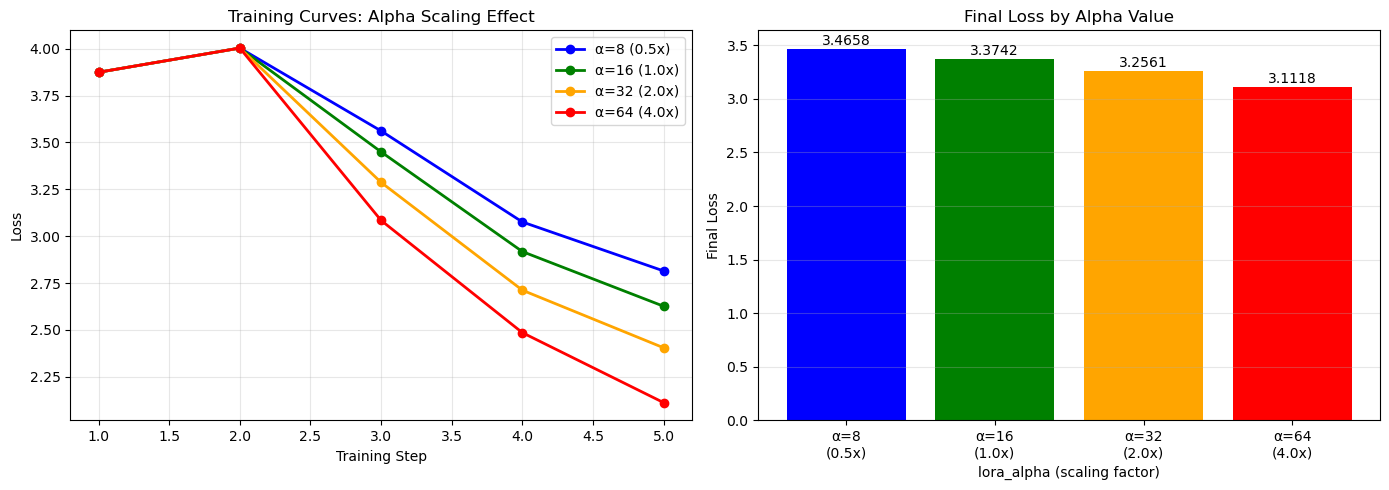


Visualization saved to outputs_qlora_alpha_ministral/alpha_comparison.png


In [5]:
# Results Visualization
import pandas as pd
import matplotlib.pyplot as plt

# Summary table
summary_data = [{
    "alpha": r["alpha"],
    "scaling": f"{r['scaling_factor']:.1f}x",
    "final_loss": r["final_loss"],
} for r in results]

df = pd.DataFrame(summary_data)

print("\n" + "="*60)
print("Alpha Scaling Comparison Results")
print("="*60)
print(df.to_string(index=False))

# Create visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Training Curves
colors = ['blue', 'green', 'orange', 'red']
for i, result in enumerate(results):
    if result['loss_history']:
        steps = [h['step'] for h in result['loss_history']]
        losses = [h['loss'] for h in result['loss_history']]
        label = f"α={result['alpha']} ({result['scaling_factor']:.1f}x)"
        axes[0].plot(steps, losses, '-o', color=colors[i], linewidth=2, markersize=6, label=label)

axes[0].set_title('Training Curves: Alpha Scaling Effect', fontsize=12)
axes[0].set_xlabel('Training Step')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Final Loss Bar Chart
alphas = [r['alpha'] for r in results]
final_losses = [r['final_loss'] for r in results]
x_labels = [f"α={a}\n({a/FIXED_RANK:.1f}x)" for a in alphas]

bars = axes[1].bar(x_labels, final_losses, color=colors)
axes[1].set_title('Final Loss by Alpha Value', fontsize=12)
axes[1].set_xlabel('lora_alpha (scaling factor)')
axes[1].set_ylabel('Final Loss')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, loss in zip(bars, final_losses):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                 f'{loss:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('outputs_qlora_alpha_ministral/alpha_comparison.png', dpi=150)
plt.show()

print("\nVisualization saved to outputs_qlora_alpha_ministral/alpha_comparison.png")

## Analysis and Key Findings

### Alpha Scaling Formula
The effective LoRA contribution is scaled by `alpha/r`:
- `h = h + (alpha/r) * LoRA(x)`
- This acts as a learning rate multiplier for adapter weights

### Observed Behavior

**α=8 (0.5x scaling):**
- Conservative updates
- Slower convergence
- May need more training steps
- Most stable, lowest risk of overfitting

**α=16 (1.0x scaling - Standard):**
- Balanced updates
- Standard configuration (α = r)
- Good default for most tasks

**α=32 (2.0x scaling):**
- Aggressive updates
- Faster convergence
- May overshoot optimal values

**α=64 (4.0x scaling):**
- Very aggressive updates
- Fastest initial convergence
- Higher risk of instability
- May need lower learning rate to compensate

### Recommendations

| Use Case | Alpha | Scaling |
|----------|-------|--------|
| Conservative/stable | α=8 | 0.5x |
| General purpose | α=16 | 1.0x |
| Faster convergence | α=32 | 2.0x |
| Quick experiments | α=64 | 4.0x (reduce LR) |

### Key Insight
When using high alpha values (>r), consider reducing the learning rate proportionally to maintain stability.

### Model Notes
- **Model:** Ministral-3B-Reasoning (3B parameters)
- **Reasoning Format:** `[THINK]...[/THINK]` tags (native Ministral format)
- Results may differ from larger models due to parameter count differences

In [6]:
# Shutdown kernel to release all GPU memory
import IPython
print("Shutting down kernel to release GPU memory...")
app = IPython.Application.instance()
app.kernel.do_shutdown(restart=False)

Shutting down kernel to release GPU memory...


{'status': 'ok', 'restart': False}